# MLNS Kaggle Challenge

#### Imports

In [1]:
"""
Machine Learning in Network Science
Kaggle Challenge : Link Prediction
"""
import os
import csv
import networkx as nx
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.sparse import *
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score

#### Load

In [2]:
DATA_PATH = 'centralesupelec-mlns-2024/'
G_train = nx.Graph()

# Read Node Features
node_features = {}
with open(DATA_PATH + 'node_information.csv', 'r') as file:
    for line in file:
        node_id, *feature_values = map(str, line.strip().split(','))
        node_features[int(node_id)] = np.array(feature_values)  # Convert feature values to a numpy array

# Add nodes to the graph with features
for node_id, feature_vector in node_features.items():
    G_train.add_node(node_id, feature=feature_vector)

# Create Graph from known edges and read training set negative examples

given_non_edges = []
with open(DATA_PATH + 'train.txt', 'r') as file:
    for line in file:
        node1, node2, edge_indicator = map(int, line.split())
        if edge_indicator == 1:
            G_train.add_edge(node1, node2)
        else:
            given_non_edges.append((node1, node2))

# Read list of edges to be predicted for the competition
pred_set = []
with open(DATA_PATH + 'test.txt', 'r') as file:
    for line in file:
        node1, node2 = map(int, line.split())
        pred_set.append((node1, node2))

#### Explore

In [3]:
print("The number of nodes: {}".format(G_train.number_of_nodes()))
print("The number of edges: {}".format(G_train.number_of_edges()))
print("The number of connected components: {}".format(nx.number_connected_components(G_train)))

The number of nodes: 3597
The number of edges: 5248
The number of connected components: 1


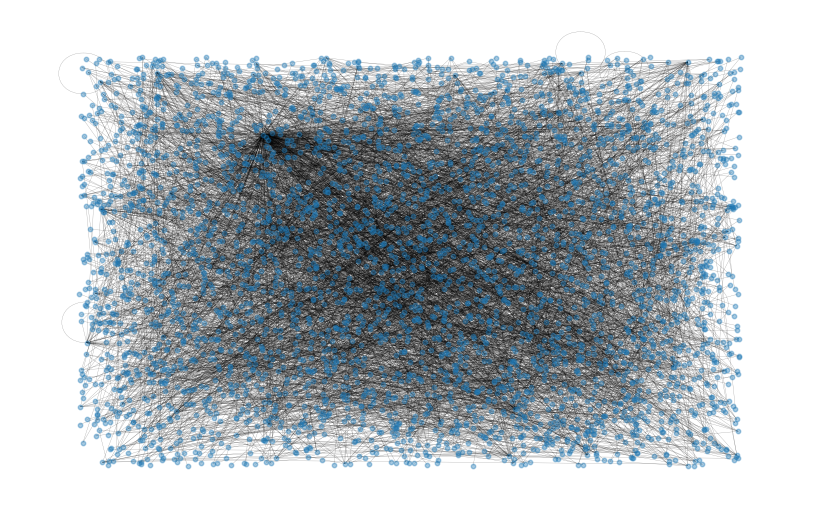

In [4]:
# Plot graph
plt.figure(figsize=(8,5))
pos = nx.random_layout(G_train, seed=19)
nx.draw(G_train, with_labels=False, pos=pos, node_size = 10, alpha = 0.4, width = 0.2)
plt.show()

#### Data Preprocessing

Train - Test Split

In [5]:
# Load dataset
given_edges = list(G_train.edges())
num_edges   = len(given_edges)
num_non_edges = len(given_non_edges)

# shuffle the lists of edges, and non edges
np.random.seed(0)
np.random.shuffle(given_edges)
np.random.shuffle(given_non_edges)

# split into balanced train and test set
train_size = .7
num_train_edges = int(num_edges * train_size)
num_test_edges  = num_edges - num_train_edges
k = num_test_edges 

# split into train and val while keeping graph connected
residual_g   = G_train.copy()
pos_test_set = list(residual_g.edges())
np.random.shuffle(pos_test_set)
val_edges = []
i=0
for edge in pos_test_set:
    residual_g.remove_edge(edge[0], edge[1]) 
    if not nx.is_connected(residual_g):
        residual_g.add_edge(edge[0], edge[1])
    else: 
        i += 1
        val_edges.append(edge)
    if i == num_test_edges:
        break

# split shuffled lists into train and val
train_edges     = list(set(given_edges).difference(set(val_edges)))
train_non_edges = given_non_edges[0:num_train_edges]
val_edges       = val_edges
val_non_edges   = given_non_edges[num_train_edges:num_train_edges+num_test_edges]
non_edges_train = list(nx.non_edges(residual_g))

# Print size of resulting positive and negative examples
print('Train edges [positive] ', len(train_edges))
print('Train edges [negative] ', len(train_edges))
print('Val edges   [positive] ', len(val_edges))
print('Val edges   [negative] ', len(val_edges))
print('Non-edges   [        ] ', len(non_edges_train))

Train edges [positive]  3673
Train edges [negative]  3673
Val edges   [positive]  1575
Val edges   [negative]  1575
Non-edges   [        ]  6463746


Train - Test Samples and Labels

In [6]:
# For training set
train_samples   = train_edges + train_non_edges
train_labels    = [1 for _ in train_edges] + [0 for _ in train_non_edges]
# For testing set
test_samples    = val_edges + val_non_edges
test_labels     = [1 for _ in val_edges] + [0 for _ in val_non_edges]

Extract Features

In [7]:
def feature_extractor(graph, samples):
    """
    Creates a feature vector for each edge of the graph contained in samples 
    """
    feature_vector = []
    
    # Degree Centrality measure
    deg_centrality = nx.degree_centrality(graph)
    
    # Betweeness centrality measure
    betweeness_centrality = nx.betweenness_centrality(graph)
    
    # EigenCentrality measure
    eigen_centrality = nx.eigenvector_centrality(graph)
    
    # PageRank measure
    pagerank = nx.pagerank(graph)
    
    # Clustering Coefficient measure
    clustering_coefficient = nx.clustering(graph)

    # SimRank measure
    simrank = nx.simrank_similarity(graph)

    for edge in tqdm(samples):
        source_node, target_node = edge[0], edge[1]

        # Degree Centrality
        source_degree_centrality = deg_centrality[source_node]
        target_degree_centrality = deg_centrality[target_node]
        
        # Betweeness centrality measure 
        diff_bt = betweeness_centrality[target_node] - betweeness_centrality[source_node]

        # EigenCentrality
        source_eigen_centrality = eigen_centrality[source_node]
        target_eigen_centrality = eigen_centrality[target_node]

        # PageRank
        source_pagerank = pagerank[source_node]
        target_pagerank = pagerank[target_node]

        # Clustering Coefficient
        source_clustering_coefficient = clustering_coefficient[source_node]
        target_clustering_coefficient = clustering_coefficient[target_node]

        # Preferential Attachement 
        pref_attach = list(nx.preferential_attachment(graph, [(source_node, target_node)]))[0][2]

        # AdamicAdar
        try: 
            aai = list(nx.adamic_adar_index(graph, [(source_node, target_node)]))[0][2]
        except:
            aai = 0

        # Jaccard
        jacard_coeff = list(nx.jaccard_coefficient(graph, [(source_node, target_node)]))[0][2]

        # SimRank
        simrank_score = simrank[source_node][target_node]

        # Create edge feature vector with all metric computed above
        feature_vector.append(np.array([source_degree_centrality, target_degree_centrality, 
                                        diff_bt, source_eigen_centrality, target_eigen_centrality,
                                        source_pagerank, target_pagerank,
                                        source_clustering_coefficient, target_clustering_coefficient,
                                        pref_attach, aai, jacard_coeff,simrank_score]) ) 
        
    return np.array(feature_vector)


In [8]:
# --- Create feature vector for all edges in training set and test set ---
train_features = feature_extractor(residual_g, train_samples)
test_features = feature_extractor(residual_g, test_samples)

100%|██████████| 3150/3150 [00:00<00:00, 77626.20it/s]


In [9]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances 

def extract_node_feature_similarity(graph, samples):
    # Compute cosine similarity between all pairs of nodes
    feature_vector = []
    node_features = nx.get_node_attributes(graph, 'feature')
    num_nodes = len(graph.nodes)
    feature_dim = 932

    # Compute similarity for all node pairs
    for sample in samples:
        u, v = sample
        feature_i = np.array(node_features[u]).reshape(1, -1)
        feature_j = np.array(node_features[v]).reshape(1, -1)
        ij_matrix = np.array([feature_i.ravel(),feature_j.ravel()],dtype='float')
        
        cos_similarity  = cosine_similarity(feature_i, feature_j)[0][0]
        jacc_sim        = pairwise_distances(np.array(ij_matrix,dtype='bool'),metric='jaccard')[0][1]
        eucl_dist       = pairwise_distances(ij_matrix,metric='euclidean')[0][1]

        feature_vector.append([cos_similarity, jacc_sim, eucl_dist])
    
    return np.array(feature_vector)

In [10]:
train_features  = np.c_[train_features,extract_node_feature_similarity(G_train, train_samples)]
test_features   = np.c_[test_features,extract_node_feature_similarity(G_train, test_samples)]

#### Node2Vec

[GitHub: Node2Vec](https://github.com/eliorc/node2vec)

In [11]:
from node2vec import Node2Vec

/Users/peterkeszthelyi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [12]:
# Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
node2vec = Node2Vec(G_train, dimensions=32, walk_length=3, num_walks=8, workers=4, p=.2, q=.2)

# Embed nodes
model = node2vec.fit(window=8, min_count=0, batch_words=4)

feature_func = lambda x,y: np.concatenate([x,y])
node2embedding = model.wv
train_node_embeddings = np.array([feature_func(node2embedding[str(u)], node2embedding[str(v)]) for (u, v) in train_samples])
test_node_embeddings  = np.array([feature_func(node2embedding[str(u)], node2embedding[str(v)]) for (u, v) in test_samples])

clf = LogisticRegression()
clf.fit(train_node_embeddings,train_labels)

print(f"Accuracy Score {accuracy_score(test_labels, clf.predict(test_node_embeddings)):.2f}")

Computing transition probabilities:   0%|          | 0/3597 [00:00<?, ?it/s]

/Users/peterkeszthelyi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/peterkeszthelyi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/peterkeszthelyi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Generating walks (CPU: 2):   0%|          | 0/2 [00:00<?, ?it/s]/Users/peterkeszthelyi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.

Accuracy Score 0.81


In [13]:
#train_features  = np.c_[train_features, train_node_embeddings]
#test_features   = np.c_[test_features, test_node_embeddings  ]

Fit and Evaluate Classifier

* classifier 1 – fitting the graph-theoretical measure featuers

In [14]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for grid search
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

# Initialize SVC classifier
svc = SVC(probability=True)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring='accuracy',n_jobs=-1)
grid_search.fit(train_features, train_labels)

# Get the best parameters found by grid search
best_params = grid_search.best_params_

# Initialize SVC classifier with the best parameters
best_svc = SVC(probability=True, **best_params)

# Train the SVC classifier with the best parameters
best_svc.fit(train_features, train_labels)

# Predict labels for test features
predicted_labels1 = best_svc.predict(test_features)

# Calculate accuracy score
accuracy = accuracy_score(test_labels, predicted_labels1)

print(f"Best Parameters: {best_params}")
print(f"Accuracy Score: {accuracy:.2f}")


Best Parameters: {'C': 1, 'kernel': 'sigmoid'}
Accuracy Score: 0.74


* classifier 2 – fitting the nod2vec embeddings

In [15]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for grid search
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

# Initialize SVC classifier
svc = SVC(probability=True)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring='accuracy',n_jobs=-1)
grid_search.fit(train_node_embeddings, train_labels)

# Get the best parameters found by grid search
best_params = grid_search.best_params_

# Initialize SVC classifier with the best parameters
best_svc2 = SVC(probability=True, **best_params)

# Train the SVC classifier with the best parameters
best_svc2.fit(train_node_embeddings, train_labels)

# Predict labels for test features
predicted_labels2 = best_svc2.predict(test_node_embeddings)

# Calculate accuracy score
accuracy = accuracy_score(test_labels, predicted_labels2)

print(f"Best Parameters: {best_params}")
print(f"Accuracy Score: {accuracy:.2f}")

Best Parameters: {'C': 10, 'kernel': 'rbf'}
Accuracy Score: 0.79


In [16]:
newX_train  = np.c_[best_svc.predict_proba(train_features)[:,1],best_svc2.predict_proba(train_node_embeddings)[:,1]]
newX_test   = np.c_[best_svc.predict_proba(test_features)[:,1],best_svc2.predict_proba(test_node_embeddings)[:,1]]

clf = LogisticRegression(C=.5)
clf.fit(newX_train,train_labels)

# Calculate accuracy score
accuracy = accuracy_score(test_labels, clf.predict(newX_test))

print(f"Best Parameters: {best_params}")
print(f"Accuracy Score: {accuracy:.2f}")

Best Parameters: {'C': 10, 'kernel': 'rbf'}
Accuracy Score: 0.79


In [17]:
def plot_roc_auc(test_preds, test_labels):
    # --- Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predictions ---
    # Fill in the blanks
    fpr, tpr, _ = roc_curve(test_labels, test_preds)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()

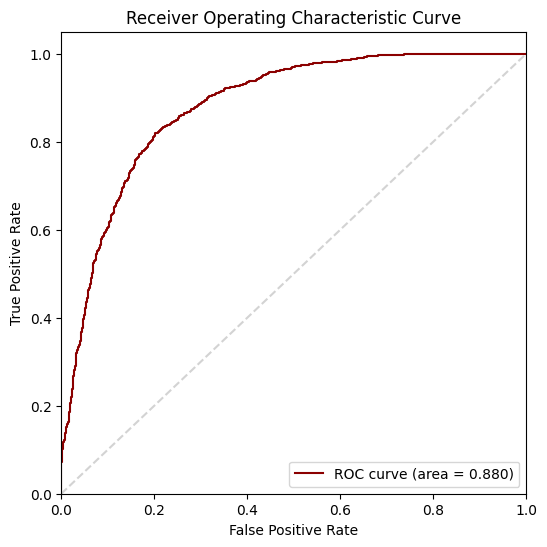

In [18]:
train_preds = clf.predict_proba(newX_train)[:, 1]
test_preds = clf.predict_proba(newX_test)[:, 1]
plot_roc_auc(test_preds, test_labels)

#### Submission

In [20]:
full_train      = np.concatenate([train_features,test_features])
full_node_emb   = np.concatenate([train_node_embeddings,test_node_embeddings])
full_label_set = np.concatenate([train_labels,test_labels])

In [23]:
clf1 = SVC(C=1,kernel='sigmoid')
clf2 = SVC(C=10, kernel='rbf')
clf1.fit(full_train,full_label_set)
clf2.fit(full_node_emb,full_label_set)
clf3 = LogisticRegression()
clf3.fit(np.c_[clf1.predict(full_train),clf2.predict(full_node_emb)],full_label_set)

LogisticRegression()

In [24]:
pred_features = feature_extractor(G_train, pred_set)
pred_features  = np.c_[pred_features, extract_node_feature_similarity(G_train, pred_set)]
pred_node2vec_embeddings = np.array([feature_func(node2embedding[str(u)], node2embedding[str(v)]) for (u, v) in pred_set])
#pred_features = np.c_[pred_features, pred_node2vec_embeddings]

100%|██████████| 3498/3498 [00:00<00:00, 68949.08it/s]


In [25]:
# Make predictions
y_preds = clf3.predict(np.c_[clf1.predict(pred_features), clf2.predict(pred_node2vec_embeddings)])

In [26]:
def generate_submission_csv(y_preds):
    preds_array = zip(np.array(range(3498)), y_preds)

    # note: Kaggle requires that you add "ID" and "category" column headers
    with open("submission.csv","w") as pred:
        csv_out = csv.writer(pred)
        csv_out.writerow(i for i in ["ID", "Predicted"])
        for row in preds_array:
            csv_out.writerow(row)
        pred.close()

In [27]:
generate_submission_csv(y_preds)